# Итоговый проект: уменьшение потребления электроэнергии на этапе обработки стали посредством МО

# Описание
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. **Наша задача — построить модель, которая будет её предсказывать.**

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

# Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:

**data_arc_new.csv** — данные об электродах;
**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
**data_gas_new.csv** — данные о продувке сплава газом;
**data_temp_new.csv** — результаты измерения температуры;
**data_wire_new.csv** — данные о проволочных материалах (объём);
**data_wire_time_new.csv** — данные о проволочных материалах (время).

**1. Файл data_arc_new.csv**

key — номер партии;
Начало нагрева дугой — время начала нагрева;
Конец нагрева дугой — время окончания нагрева;
Активная мощность — значение активной мощности;
Реактивная мощность — значение реактивной мощности.

**2. Файл data_bulk_new.csv**

key — номер партии;
Bulk 1 … Bulk 15 — объём подаваемого материала.

**3. Файл data_bulk_time_new.csv**

key — номер партии;
Bulk 1 … Bulk 15 — время подачи материала.

**4. Файл data_gas_new.csv**

key — номер партии;
Газ 1 — объём подаваемого газа.

**5. Файл data_temp_new.csv**

key — номер партии;
Время замера — время замера;
Температура — значение температуры.

**6. Файл data_wire_new.csv**

key — номер партии;
Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

**7. Файл data_wire_time_new.csv**

Wire 1 … Wire 9 — время подачи проволочных материалов.
Во всех файлах столбец key содержит номер партии

# Загрузка необходимых библиотек

In [1]:
!pip install shap

In [2]:
#загружаем библиотеки для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# загружаем библиотеки для подготовки данных
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
# загружаем функцию для работы с метриками
from sklearn.metrics import r2_score, mean_absolute_error

# импортируем класс GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import shap

Зададим константы.

In [3]:
RANDOM_STATE = 141024

## Загрузка данных

Считаем данные.

In [4]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=['Время замера'])
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Создадим словарь датасетов для удобства при исследовании.

In [5]:
datas = {'data_arc': data_arc,
         'data_bulk': data_bulk,
         'data_bulk_time': data_bulk_time,
         'data_gas': data_gas,
         'data_temp': data_temp,
         'data_wire': data_wire,
         'data_wire_time': data_wire_time}

Проверим на корректность считывания.

In [6]:
for name, data in datas.items():
    print('Датасет:', name)
    display(data.head())

Датасет: data_arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Датасет: data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датасет: data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Датасет: data_gas


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Датасет: data_temp


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Датасет: data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет: data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Все списалось корректно, в некоторых таблицах видим пропуски, посмотрим на общую информацию.

In [7]:
for name, data in datas.items():
    print('Датасет:', name)
    display(data.info())

Датасет: data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

Датасет: data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Датасет: data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Датасет: data_gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Датасет: data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

Датасет: data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Датасет: data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

**1) data_arc**

Все в порядке, пропусков нету, типы данных приведены корректно.

**2) data_bulk**

Много пропусков в определенных столбцах, но в ходе обучения выяснилось, что удаления большинства столбцов может вести к недообучению модели, поэтому удалим только столбец Bulk 8, где всего 1 значение. Пропуски в остальных таблицах заполним нулями - подачи сыпучих материалов не было.

**3) data_bulk_time**

Пропуски в этой таблице дублируют пропуски в таблице data_bulk. Это логично, если не было подачи сыпучих материалов(NaN), то и времени быть не может быть. Так же удалим те столбцы, что были перечислены в п.2. и заполним нулями оставшиеся столбцы.

**4) data_gas**

Все в порядке, пропусков нету.

**5) data_temp**

Имеем пропуски в столбце Температура, это некорректность.

**6) data_wire**

Похожая история, как и с data_bulk, много пропусков в определенных столбцах. Пойдем такой же логикой - не будем удалять много столбцов, это ведет к недообучению модели. Удалим в дальнейшем столбец Wire5, там всего 1 значение. Пропуски в остальных таблицах заполним нулями - подачи проволочных материалов не было.

**7) data_wire_time**

Аналогичная связь между data_wire и data_wire_time как у data_bulk с data_bulk_time, пропуск в одной таблице вызывает пропуск во второй. Так же удалим те столбцы, что были перечислены в п.6. и заполним нулями оставшиеся столбцы.

## Первичный исследовательский анализ

Теперь посмотрим на распределения признаков. Делать мы это будем не для всех таблиц, ибо распределения в некоторых столбцах тяжело интерпретировать, в таких как данные о подаче сыпучих и проволочных материалах, времени подачи.

Зададим функцию для удобного просмотра распределения и боксплота.

In [8]:
def hist_boxplot(data, columns):
    for column in columns:
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
        ax1.hist(data[column], bins=30)
        ax1.set_title('Распределение значений '+column)
        ax1.set_ylabel('Количество')

        ax2.boxplot(data[column], vert=False) 
        ax2.set_title('Диаграмма размаха')
        ax2.set_xlabel('Значения '+column)

        plt.xlim(data[column].min()-1, data[column].max()+1) 
        plt.tight_layout()
        plt.show()
        display(data[column].describe())

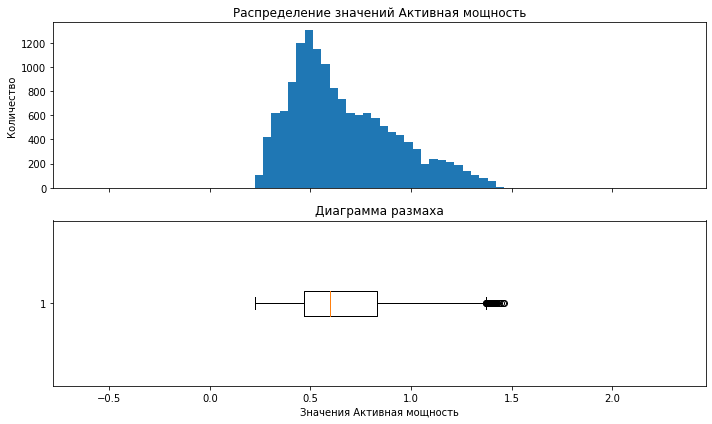

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

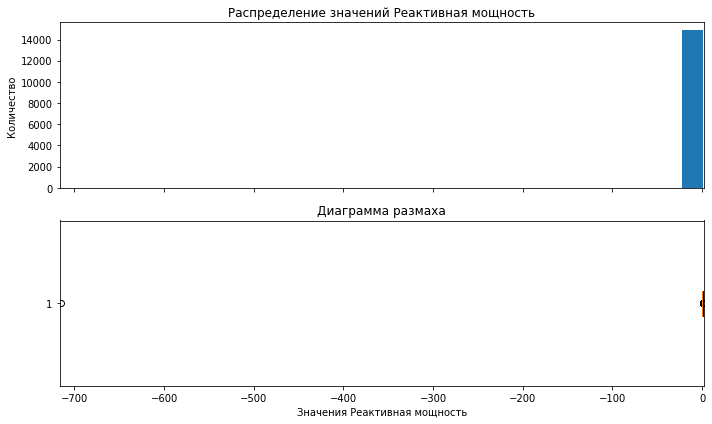

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

In [9]:
hist_boxplot(data_arc, ['Активная мощность', 'Реактивная мощность'])

По столбцам 'Активная мощность' и 'Реактивная мощность' в таблице data_arc такой вывод:

Значения активной мощности лежат в нормальных пределах, медиана равно около 0.6, выбросы согласно боксплоту есть, но удалять их или нет будем решать на тренировочной выборке.

Плохая интерпретация по столбцу 'Реактивная мощность' обусловлена отрицательным выбросом, без него картина адекватная. Поэтому в предобработке данных удалим это значение.

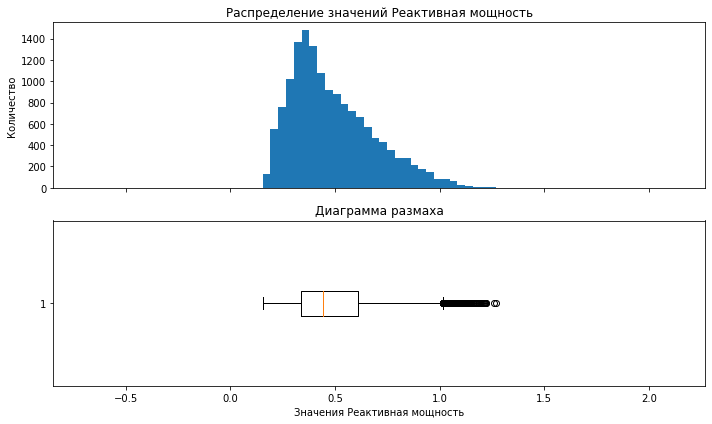

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

In [10]:
hist_boxplot(data_arc.loc[data_arc['Реактивная мощность']>0], ['Реактивная мощность'])

Видно, что количество измерений уменьшилось на один, значит значений меньше 0 только одно. При дропе аномалии медиана равна около 0.44, также по боксплоту видны выбросы при значении мощности выше 1, но удалять их или нет решим на тренировочной выборке.

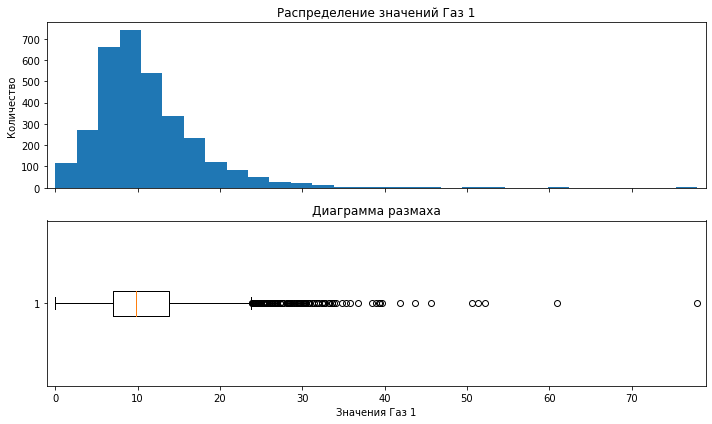

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [11]:
hist_boxplot(data_gas, ['Газ 1'])

Отрицательных значений в столбце Газ 1 таблицы data_gas нету, медиана равна около 10, выбросы по боксплоту это значения выше около 23-25, удалять их или нет решим на тренировочной выборке.

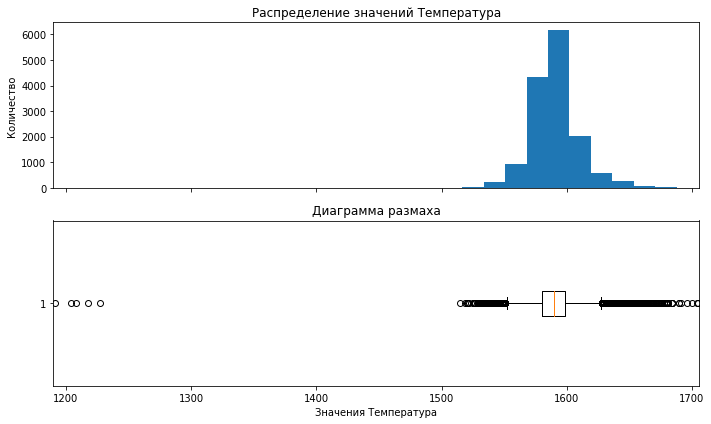

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

In [12]:
hist_boxplot(data_temp.dropna(), ['Температура'])

Есть значения температуры ниже 1500 градусов - это аномалии, удалим их в дальнейшем. По боксплоту выбросы конечно считаются те, что ниже 1550 и примерно выше 1630 градусов, но это нормальные значения, ибо в зависимости от хим добавок сталь может плавиться при той или иной температуре.

По таблицам data_bulk и data_wire выведем describe - объем материалов не может быть отрицательным. Остальные две таблицы, которые содержат время подачи, в анализе не нуждаются.

In [13]:
display(data_bulk.drop(columns=['key']).describe())
data_wire.drop(columns=['key']).describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Отрицательных значений не видим, тут все ок.

**Вывод по первичному исследовательскому анализу:**
1. Таблицы data_arс и data_gas не имеют пропусков, но в столбце реактивная мощность таблицы data_arс имеется аномальное отрицательное значение, подлежащее удалению. В остальном плане в таблицах данные адекватно распределены, имеются выбросы(по боксплоту), но эти выбросы соответствуют хвостам гистограммы и являются логичными. Удалять их или нет будет решено дальше перед обучением модели. 


2. Таблицы data_bulk, data_bulk_time, data_wire, data_wire_time имеют значительно количество пропущенных значений (свыше 90% от общего количества) в определенных столбцах, которые подлежат удалению вследствие их неинформативности на общем фоне. Остальные столбцы не содержат отрицательных значений, что хорошо. Максимальный объем материалов не определяем, ибо он может соответствовать реальности.


3. Таблица data_temp имеет пропущенные значения в столбце температура, что не норма и объяснить можно только тем, что либо техническая ошибка замера, либо замеров попросту не было, а время указано. В остальном плане температура имеет только выбросы температур, значения которых менее 1500 градусов - это аномалии, остальные выбросы по боксплоту соответствуют логике и не противоречат процессу.

## Предобработка и объединение данных

Удалим все, что хотели.

In [14]:
data_arc_new = data_arc.loc[data_arc['Реактивная мощность']>0]

По условию мы должны удалить те ключи, в которых замеры температуры провелись единожды. Количество замеров мы можем определить и по таблице data_arc, но чтобы определить была ли зафиксирована температура, обратимся к таблице data_temp и удалим ключи, количество замеров для которых равно 1.

In [15]:
data_help = data_temp.pivot_table(index='key', aggfunc=['count'])
keys_to_delete = list(data_help.loc[data_help[('count',  'Температура')]<2].index)
data_temp_new = data_temp.loc[~data_temp['key'].isin(keys_to_delete)]
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Сравним таблицы до и после удалений.

In [16]:
display(data_temp.info())
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   Время замера  13924 non-null  datetime64[ns]
 2   Температура   13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.1 KB


И пропуски удалили, и оставили только пригодные ключи, удачно.

Помним, что температуры ниже 1500 градусов считаем аномалиями, поэтому удаляем их тоже

In [17]:
data_temp_new = data_temp_new.loc[data_temp_new['Температура']>1500]
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13920 non-null  int64         
 1   Время замера  13920 non-null  datetime64[ns]
 2   Температура   13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


С этим разобрались, теперь удалим ненужные столбцы в таблицах 'data_bulk', 'data_bulk_time', 'data_wire', 'data_wire_time' и заполним оставшиеся пропуски нулями.

In [18]:
data_bulk_new = data_bulk.drop(columns=['Bulk 8'], axis=1).fillna(0)
data_bulk_time_new = data_bulk_time.drop(columns=['Bulk 8'], axis=1).fillna(0)
data_wire_new = data_wire.drop(columns=['Wire 5'], axis=1).fillna(0)
data_wire_time_new = data_wire_time.drop(columns=['Wire 5'], axis=1).fillna(0)
display(data_bulk_new.head())
display(data_bulk_time_new.head())
display(data_wire_new.head())
data_wire_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0


Все корректно.

Теперь разберемся с промежуточными значениями температуры. Поскольку они являются утечкой информации, то мы должны оставить только первую температуру - будет обычным признаком, и последнюю температуру - целевой признак. Решим эту задачу, создав новую таблицу, которая будет содержать ключ, начальную и конечную температуру. 

In [19]:
#создадим массив, в котором будем хранить подмассивы размером 3,
#в которых первое значение будет ключ, второе и третье начальная и конечная температура соответственно
temps = []
for key in data_temp_new['key'].unique():
    temp_data = data_temp_new.loc[data_temp_new['key']==key]
    temps.append([key,
                  temp_data['Температура'][temp_data['Время замера'] == temp_data['Время замера'].min()].iloc[0],
                  temp_data['Температура'][temp_data['Время замера'] == temp_data['Время замера'].max()].iloc[0]])

In [20]:
data_start_end_temp = pd.DataFrame(temps, columns=['key', 'Начальная температура', 'Конечная температура'])
data_start_end_temp.head()

,key,Начальная температура,Конечная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Если сравнивать первые два ключа по прошлой таблице, то все корректно.

Вернемся к таблицам data_bulk_time и data_wire_time. Нам нужно проверить корректность данных, а именно для каждого ключа время замера последней температуры не может быть меньше последней введенной добавки, а так же время первого(стартового) измерения температуры не может быть больше, чем первая введенная добавка.

In [21]:
time_valid = []
for key in data_start_end_temp['key'].unique():
    temp_data = data_temp_new[data_temp_new['key'] == key]
    data_bulk_time_key = data_bulk_time_new[data_bulk_time_new['key'] == key]
    data_wire_time_key = data_wire_time_new[data_wire_time_new['key'] == key]
    if not (data_bulk_time_key.empty or data_wire_time_key.empty):
        time_list_bulk = [pd.to_datetime(time) for time in data_bulk_time_new.drop(columns=['key'])[data_bulk_time_new['key']==key].iloc[0].tolist() if time != 0]
        time_list_wire = [pd.to_datetime(time) for time in data_wire_time_new.drop(columns=['key'])[data_wire_time_new['key']==key].iloc[0].tolist() if time != 0]
        if time_list_bulk and (temp_data['Время замера'].min() > min(time_list_bulk) or temp_data['Время замера'].max() < max(time_list_bulk)) or \
        time_list_wire and (temp_data['Время замера'].min() > min(time_list_wire) or temp_data['Время замера'].max() < max(time_list_wire)):
            time_valid.append(False)
        else:
            time_valid.append(True)
    else:
        time_valid.append(False)

In [22]:
display(data_start_end_temp.info())
data_start_end_temp = data_start_end_temp[time_valid]
data_start_end_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2475 non-null   int64  
 1   Начальная температура  2475 non-null   float64
 2   Конечная температура   2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2328 non-null   int64  
 1   Начальная температура  2328 non-null   float64
 2   Конечная температура   2328 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.8 KB


В итоге имеем 2328 корректных ключей на этом этапе.

Также проверим, что время первого замера производится до начала нагрева первого цикла дугой, а последнее измерение температуры производится не раньше конца нагрева дугой последнего цикла.

In [23]:
time_valid_2 = []
for key in data_start_end_temp['key'].unique():
    temp_data = data_temp_new[data_temp_new['key'] == key]
    if temp_data['Время замера'].min()>data_arc_new['Начало нагрева дугой'][data_arc_new['key']==key].min() or \
    temp_data['Время замера'].max()<data_arc_new['Конец нагрева дугой'][data_arc_new['key']==key].max():
        time_valid_2.append(False)
    else:
        time_valid_2.append(True)

In [24]:
display(data_start_end_temp.info())
data_start_end_temp = data_start_end_temp[time_valid_2]
data_start_end_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2328 non-null   int64  
 1   Начальная температура  2328 non-null   float64
 2   Конечная температура   2328 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2327 non-null   int64  
 1   Начальная температура  2327 non-null   float64
 2   Конечная температура   2327 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.7 KB


Количество значений уменьшилось на 1.

Теперь агрегируем данные по таблицам data_arc(посчитаем суммарную активную и реактивную мощность на партию).

In [25]:
data_power_sum = data_arc_new.pivot_table(index='key', values=['Активная мощность', 'Реактивная мощность'], aggfunc=np.sum)
data_power_sum.head()

,Активная мощность,Реактивная мощность
key,,
1,3.036730,2.142821
2,2.139408,1.453357
3,4.063641,2.937457
4,2.706489,2.056992
5,2.252950,1.687991


Все, теперь объединяем таблицы, начиная с data_start_end_temp, поскольку там находятся все валидные ключи. Естественно не добавляем время добавления добавок, это не пригодится при обучении.

In [26]:
data_full = data_start_end_temp.join(data_power_sum, how='inner', on='key')
data_full.head()

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность
0,1,1571.0,1613.0,3.036730,2.142821
1,2,1581.0,1602.0,2.139408,1.453357
2,3,1596.0,1599.0,4.063641,2.937457
3,4,1601.0,1625.0,2.706489,2.056992
4,5,1576.0,1602.0,2.252950,1.687991


In [27]:
data_full = data_full.merge(data_bulk_new, how='inner', on='key')
data_full.head()

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1571.0,1613.0,3.036730,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,2.139408,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,4.063641,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,2.706489,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,2.252950,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [28]:
data_full = data_full.merge(data_wire_new, how='inner', on='key')
data_full.head()

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,3.036730,2.142821,0.0,0.0,0.0,43.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,2.139408,1.453357,0.0,0.0,0.0,73.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,4.063641,2.937457,0.0,0.0,0.0,34.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,2.706489,2.056992,0.0,0.0,0.0,81.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2.252950,1.687991,0.0,0.0,0.0,78.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
data_full = data_full.merge(data_gas, how='inner', on='key')
display(data_full.head())
display(data_full.tail())
data_full.info()

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,3.036730,2.142821,0.0,0.0,0.0,43.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,2.139408,1.453357,0.0,0.0,0.0,73.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,4.063641,2.937457,0.0,0.0,0.0,34.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,2.706489,2.056992,0.0,0.0,0.0,81.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,2.252950,1.687991,0.0,0.0,0.0,78.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
2320,2495,1570.0,1591.0,3.168133,2.210936,0.0,0.0,21.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2321,2496,1554.0,1591.0,4.174918,2.872031,0.0,0.0,0.0,63.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2322,2497,1571.0,1589.0,3.605239,2.452092,0.0,0.0,0.0,85.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2323,2498,1591.0,1594.0,3.202310,2.239820,0.0,0.0,90.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,14.953657
2324,2499,1569.0,1603.0,1.737084,1.296836,0.0,0.0,47.0,0.0,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,11.336151


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2325 non-null   int64  
 1   Начальная температура  2325 non-null   float64
 2   Конечная температура   2325 non-null   float64
 3   Активная мощность      2325 non-null   float64
 4   Реактивная мощность    2325 non-null   float64
 5   Bulk 1                 2325 non-null   float64
 6   Bulk 2                 2325 non-null   float64
 7   Bulk 3                 2325 non-null   float64
 8   Bulk 4                 2325 non-null   float64
 9   Bulk 5                 2325 non-null   float64
 10  Bulk 6                 2325 non-null   float64
 11  Bulk 7                 2325 non-null   float64
 12  Bulk 9                 2325 non-null   float64
 13  Bulk 10                2325 non-null   float64
 14  Bulk 11                2325 non-null   float64
 15  Bulk

Готово. Нету ключей со значением выше 2500, всего ключей 2325, что меньше 2332. Мы на верном пути.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Исследовательский анализ

Удалим ключ из итоговой таблицы и посмотрим на все распределения получившихся признаков

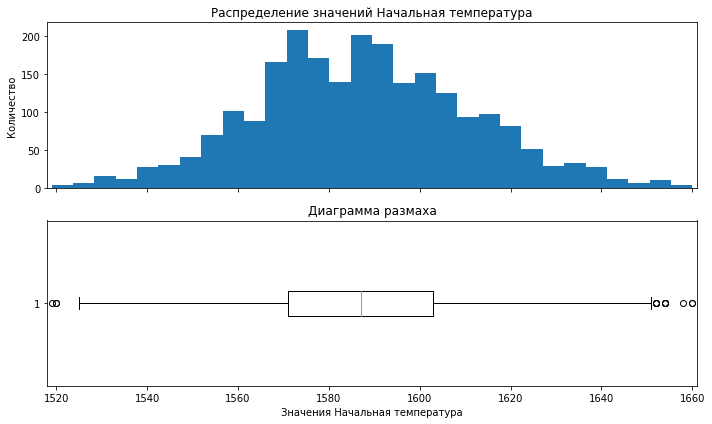

count    2325.000000
mean     1587.365161
std        23.623144
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: Начальная температура, dtype: float64

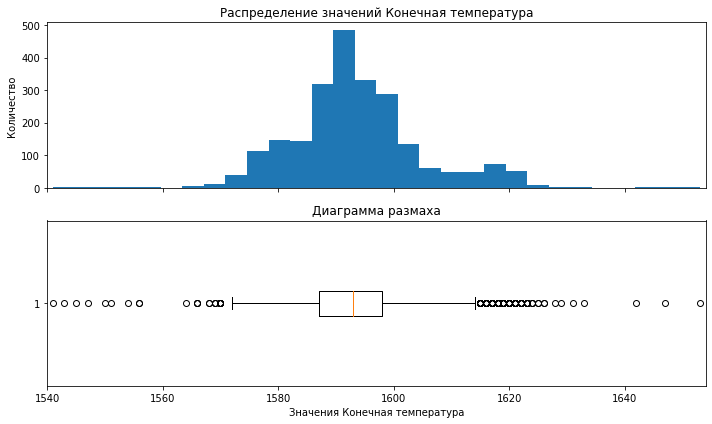

count    2325.000000
mean     1593.366022
std        11.209581
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: Конечная температура, dtype: float64

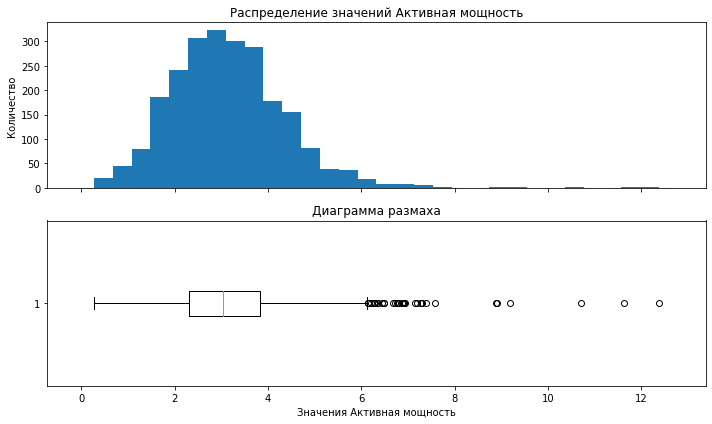

count    2325.000000
mean        3.125813
std         1.220473
min         0.267676
25%         2.295820
50%         3.036303
75%         3.834300
max        12.375636
Name: Активная мощность, dtype: float64

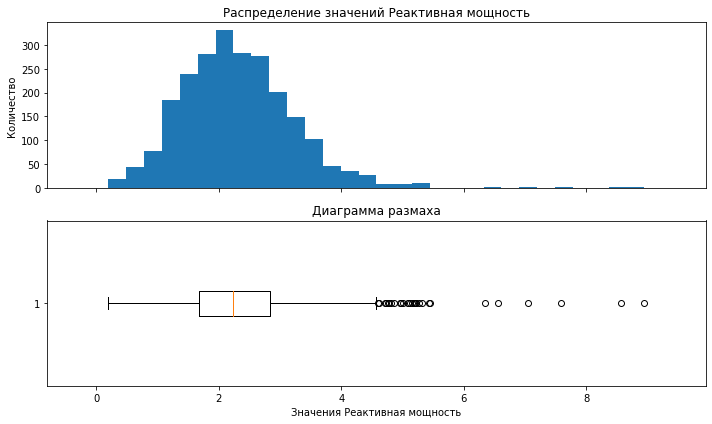

count    2325.000000
mean        2.300941
std         0.903664
min         0.196228
25%         1.670519
50%         2.225398
75%         2.829159
max         8.949049
Name: Реактивная мощность, dtype: float64

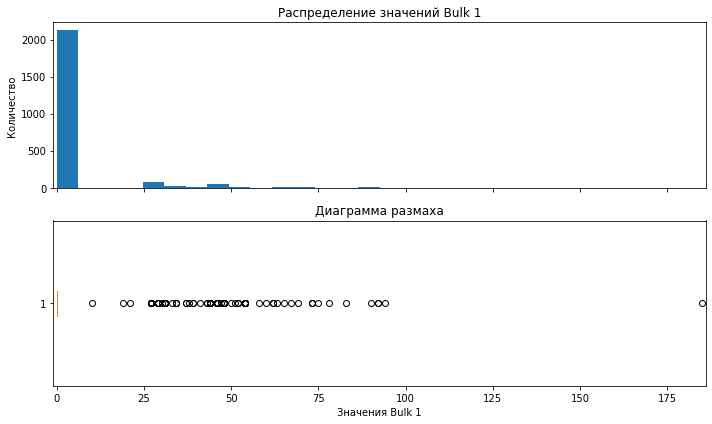

count    2325.000000
mean        3.433548
std        12.421994
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: Bulk 1, dtype: float64

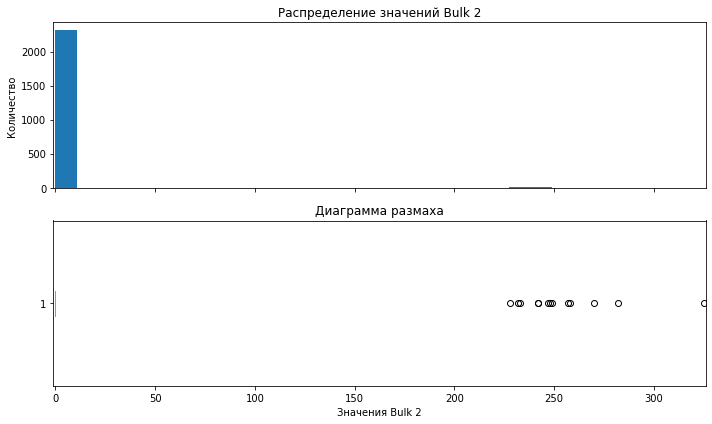

count    2325.000000
mean        1.424946
std        19.098442
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: Bulk 2, dtype: float64

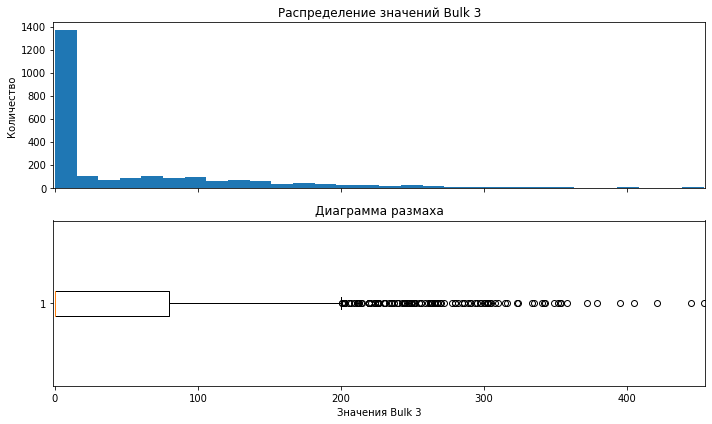

count    2325.000000
mean       47.296774
std        75.228262
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: Bulk 3, dtype: float64

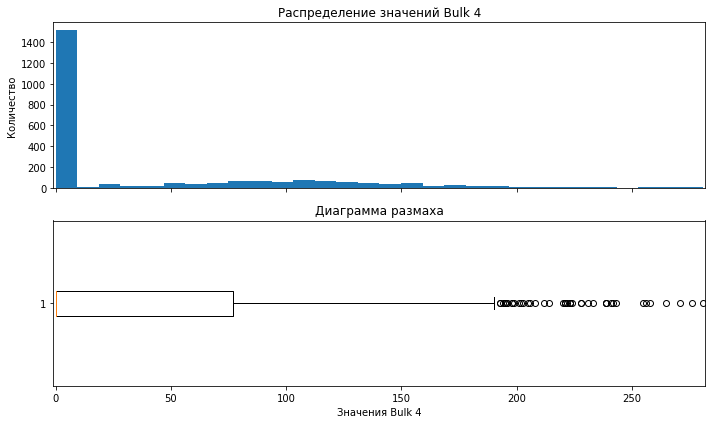

count    2325.000000
mean       37.331613
std        58.670377
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: Bulk 4, dtype: float64

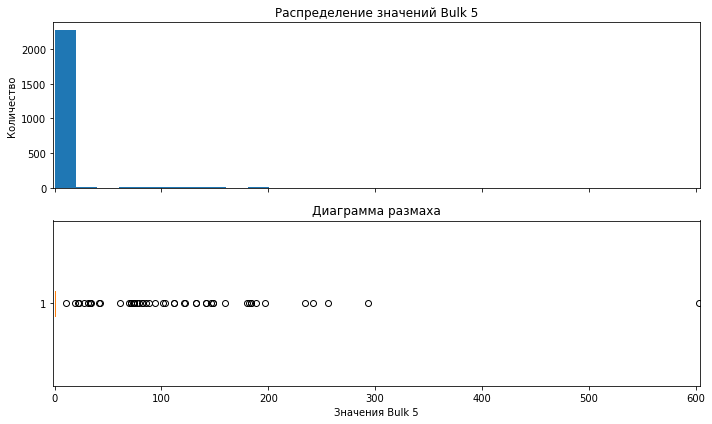

count    2325.000000
mean        2.644731
std        22.421296
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: Bulk 5, dtype: float64

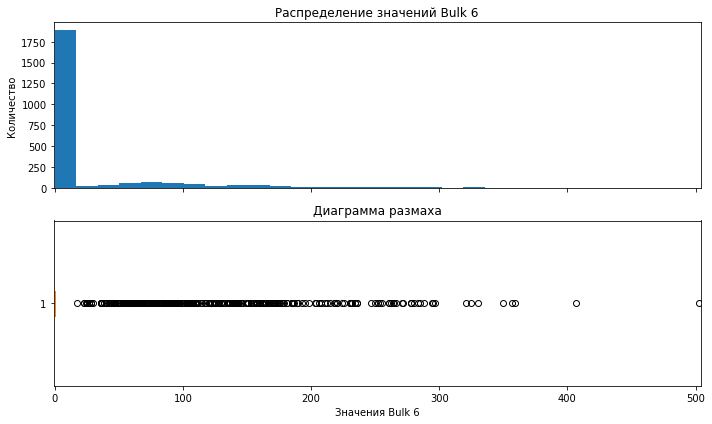

count    2325.000000
mean       22.468817
std        55.831097
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: Bulk 6, dtype: float64

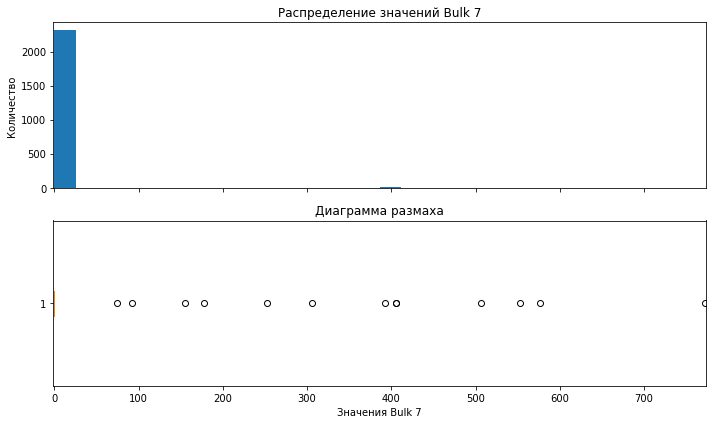

count    2325.000000
mean        2.008172
std        30.702509
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: Bulk 7, dtype: float64

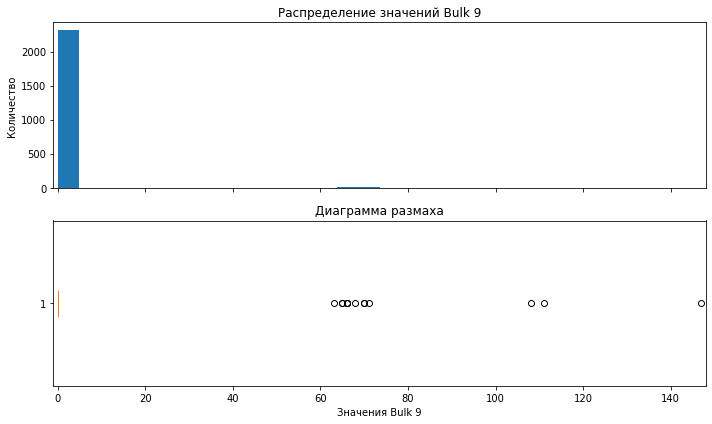

count    2325.000000
mean        0.445591
std         6.225965
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: Bulk 9, dtype: float64

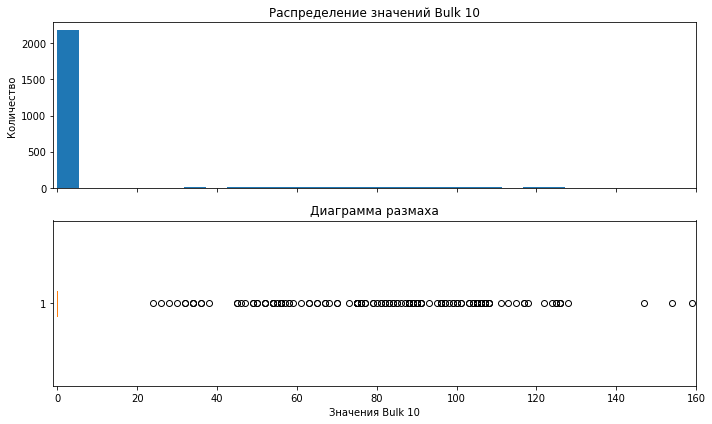

count    2325.000000
mean        5.061505
std        20.934742
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: Bulk 10, dtype: float64

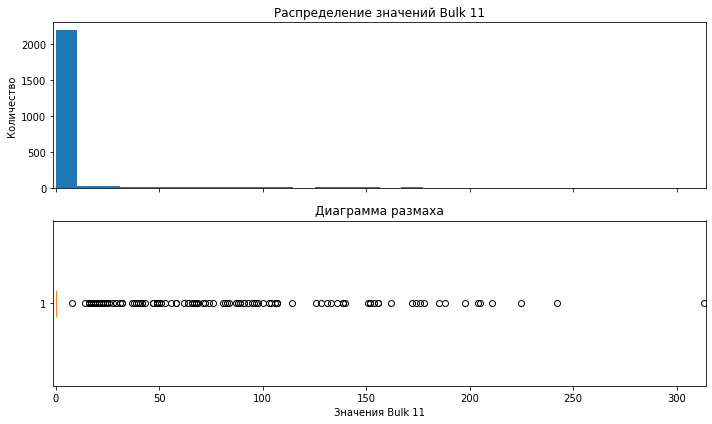

count    2325.000000
mean        4.252473
std        22.534166
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: Bulk 11, dtype: float64

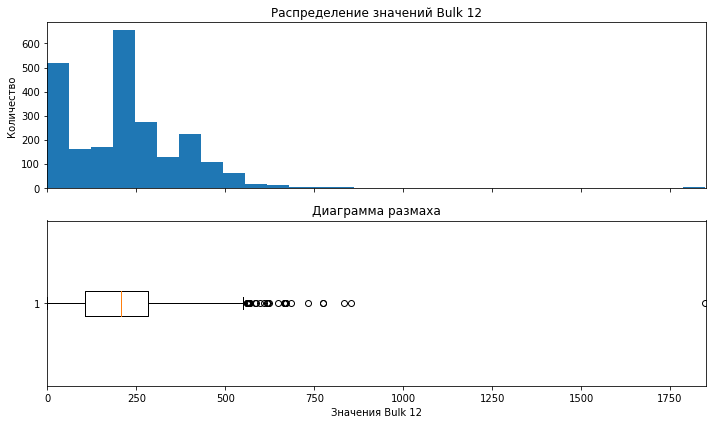

count    2325.000000
mean      208.507957
std       157.137873
min         0.000000
25%       105.000000
50%       206.000000
75%       283.000000
max      1849.000000
Name: Bulk 12, dtype: float64

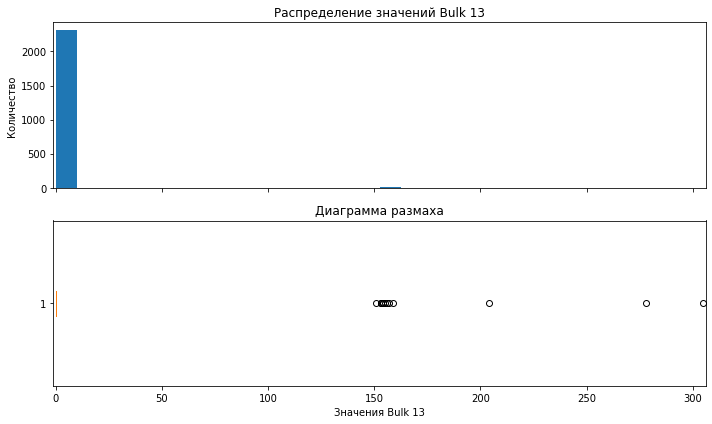

count    2325.000000
mean        1.069247
std        14.247231
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: Bulk 13, dtype: float64

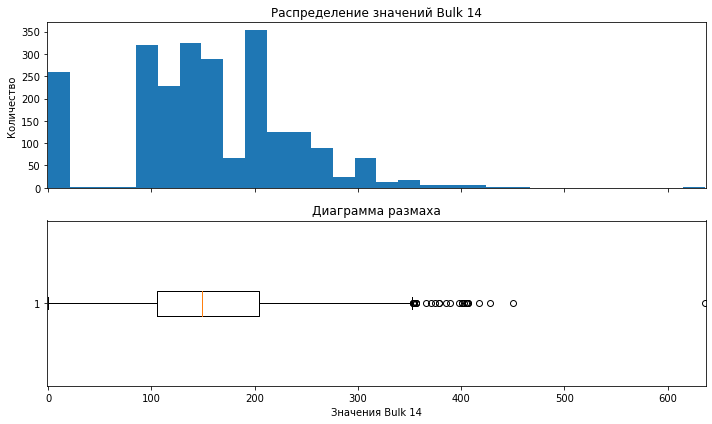

count    2325.000000
mean      153.971613
std        81.398153
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: Bulk 14, dtype: float64

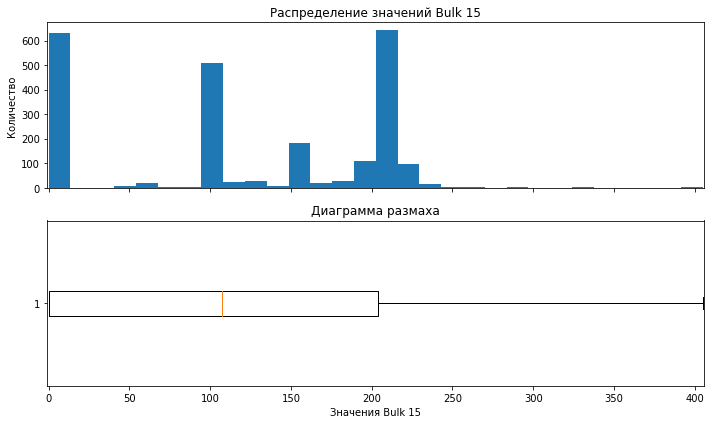

count    2325.000000
mean      120.026667
std        84.674380
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: Bulk 15, dtype: float64

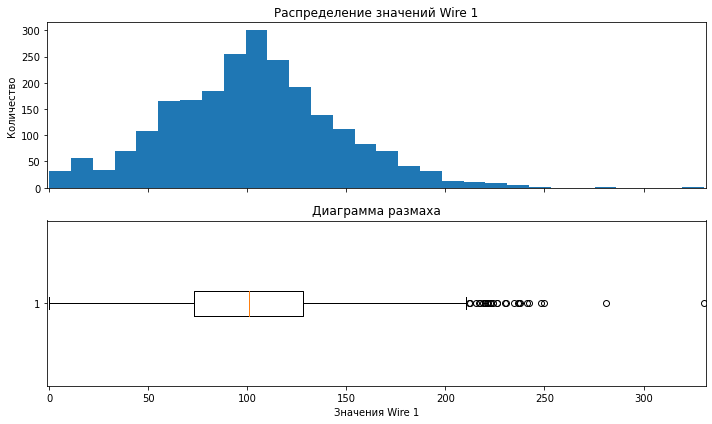

count    2325.000000
mean      102.412198
std        43.535263
min         0.000000
25%        73.207679
50%       101.087998
75%       128.069763
max       330.314424
Name: Wire 1, dtype: float64

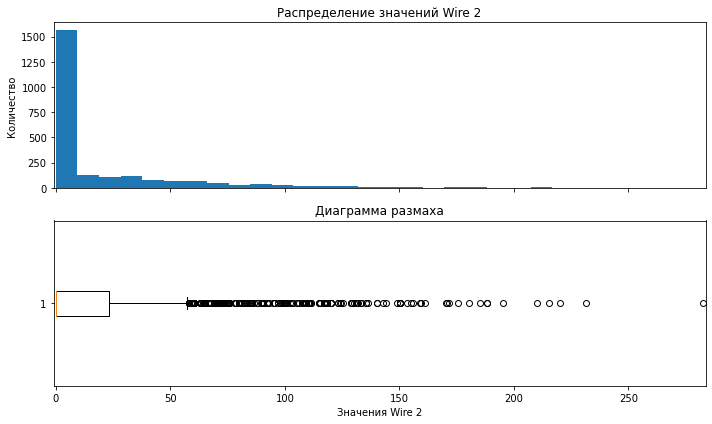

count    2325.000000
mean       17.605637
std        33.642919
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: Wire 2, dtype: float64

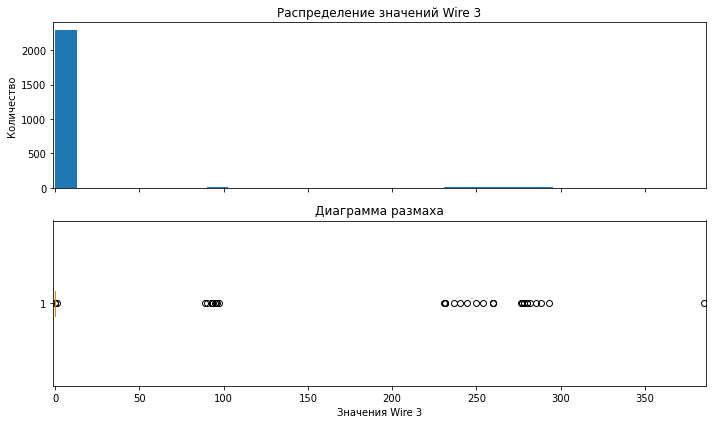

count    2325.000000
mean        3.240481
std        27.966585
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: Wire 3, dtype: float64

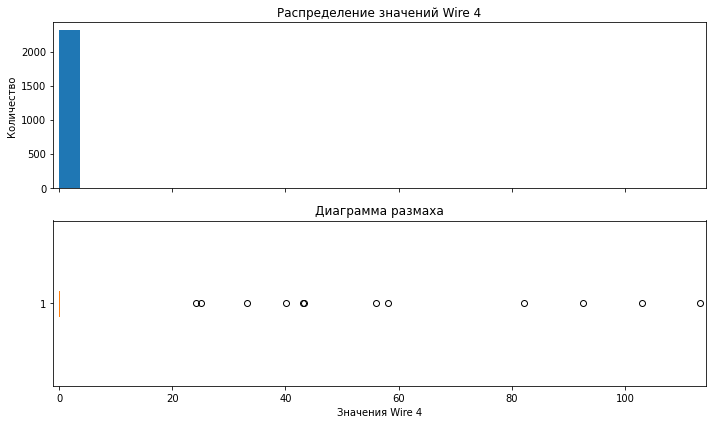

count    2325.000000
mean        0.307077
std         4.761821
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: Wire 4, dtype: float64

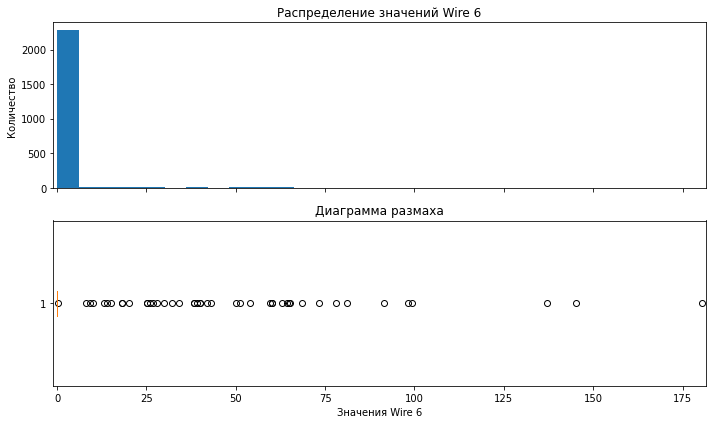

count    2325.000000
mean        0.980504
std         8.700682
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: Wire 6, dtype: float64

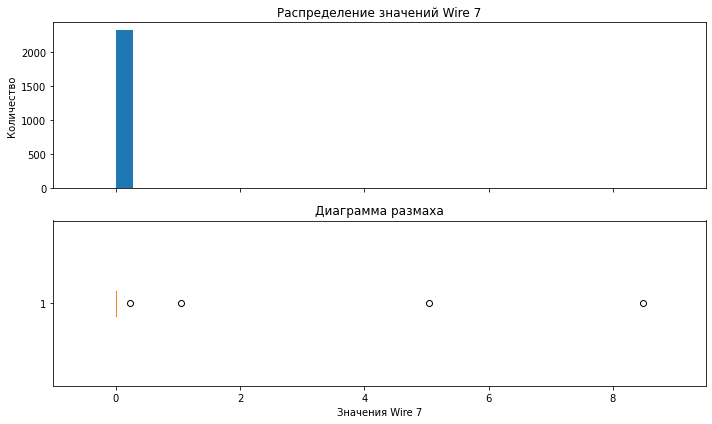

count    2325.000000
mean        0.006371
std         0.205882
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: Wire 7, dtype: float64

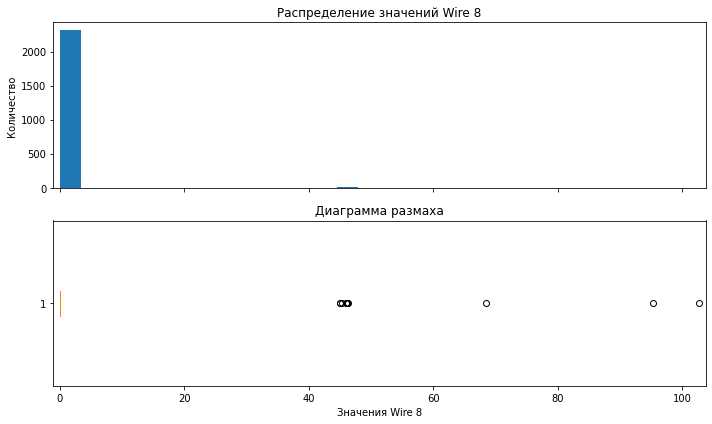

count    2325.000000
mean        0.311847
std         4.406475
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: Wire 8, dtype: float64

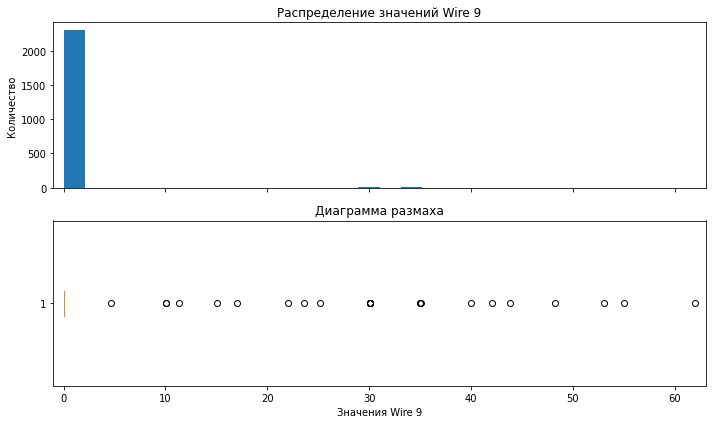

count    2325.000000
mean        0.317658
std         3.459510
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: Wire 9, dtype: float64

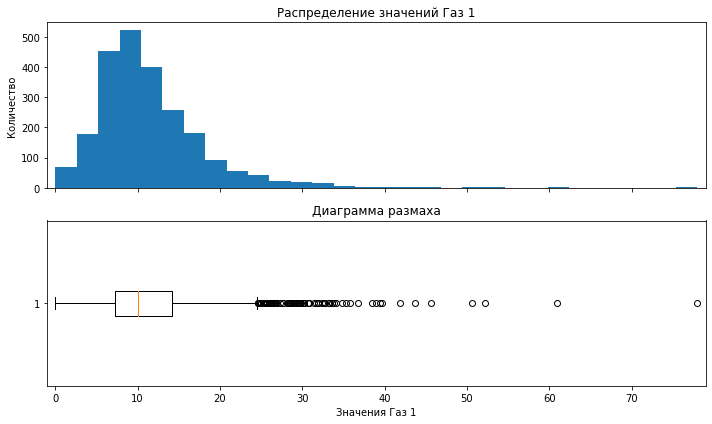

count    2325.000000
mean       11.378942
std         6.395632
min         0.008399
25%         7.282948
50%        10.100950
75%        14.217691
max        77.995040
Name: Газ 1, dtype: float64

In [30]:
#data_full = data_full.drop(columns=['key'])
hist_boxplot(data_full.drop(columns=['key']), data_full.drop(columns=['key']).columns)

1. Распределения начальной и конечной температуры похожи на нормальные, выбросы)по боксплоту) - логичное продолжение хвостов гистограммы, как и ожидалось, в среднем значение конечной температуры выше начальной.

2. Активная и реактиная мощность имеют похожие распределения, но их выбросы)по боксплоту) уже не сослать на продолжения гистограммы, они явно выражаются вдали от нее.

3. Bulk 1 - Bulk 11, Bulk 13 плохо интерпетируемы, поскольку нулю сдвигают графики к нулю, а вот Bulk12, Bulk14, Bulk15 более интерпретируемые, пропущенных значений в этих столбцах меньше всего. Выбросы(боксплоту) присутствуют, но распределения ненормальные, поэтому сложно сказать, истинные это выбросы или нет.

4. Wire1 имеет нормальное распределение. Выбросы(по боксплоту) присутствуют, но большая часть из них опять таки является логичным продолжение гистограммы, кроме значения 330 и около 280, это явный выброс. А вот Wire2 - Wire9 имеет много пропусков, поскольку видно, что медиана равна 0, интерпретация плохая.

5. Газ1 распределен нормально, но также есть явные выбросы(значения выше 40).

Проведем корреляционный анализ.

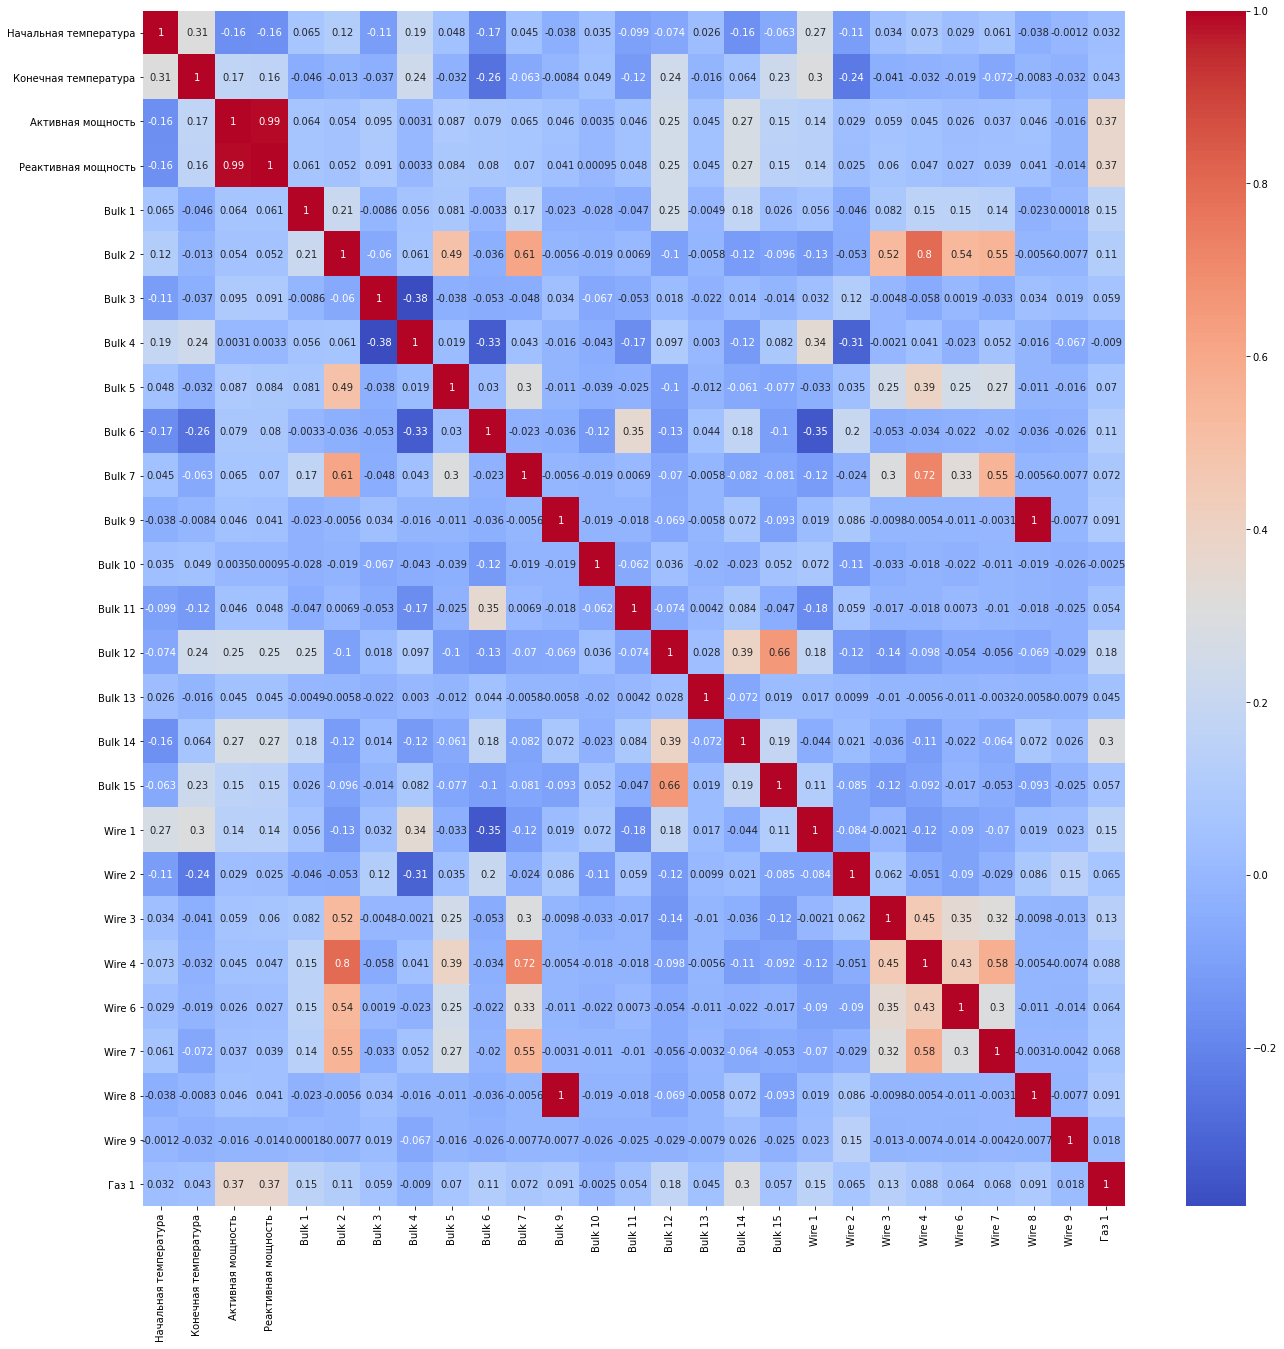

In [31]:
plt.figure(figsize = (22,22))
sns.heatmap(data_full.drop(columns=['key']).corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

Сначала поговорим о корреляции между конечной температурой и нашими признаками. Сильной связи ни с каким признаком не видно.

В остальном мультиколлинеарности обнаружена между признаками активная и реактивная мощность - 0.99, что логично. Объединим их в полную мощность. Также обнаружена мультиколлинеарность между признаком Wire 8 и Bulk 9. Удалим Bulk 9.

In [32]:
data_full['Полная мощность'] = (data_full['Активная мощность']**2+data_full['Реактивная мощность']**2)**0.5
data_full = data_full.drop(columns=['Активная мощность', 'Реактивная мощность', 'Bulk 9'])

In [33]:
data_full.head()

,key,Начальная температура,Конечная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Полная мощность
0,1,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,3.716640
1,2,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,2.586371
2,3,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,5.014163
3,4,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,3.399456
4,5,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,2.815155


### Дополнительные признаки

В ходе обучения выяснилось, что достигнуть заданной метрики при обучении на исходных данных не позволяет получить требуемую метрику, вследствие чего было принято решение добавить искусственные признаки. Добавим время полного цикла нагрева в минутах.

In [34]:
data_full_test = data_full.copy()

In [35]:
time = []
data_temp_new_1 = data_temp_new[data_temp_new['key'].isin(data_full_test['key'])]
for key in data_full_test['key'].unique():
    temp_data = data_temp_new_1.loc[data_temp_new_1['key']==key]
    time.append((temp_data['Время замера'][temp_data['Время замера'] == temp_data['Время замера'].max()].iloc[0]-temp_data['Время замера'][temp_data['Время замера'] == temp_data['Время замера'].min()].iloc[0]).seconds//60)

In [36]:
data_full_test['Время полного цикла в минутах'] = pd.Series(time).astype(int)
data_full_test = data_full_test.drop(columns=['key'])
data_full_test.head()

,Начальная температура,Конечная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 10,...,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Полная мощность,Время полного цикла в минутах
0,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,3.716640,28
1,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,2.586371,21
2,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,5.014163,29
3,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,3.399456,20
4,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,2.815155,25


## Подготовка данных

Выполним подготовку данных для обучения модели. Разделим данные на две выборки. Сразу отсечем ненужные столбцы ('Bulk 5', 'Wire 6', 'Bulk 3', 'Bulk 11'), поскольку анализ признаков после обучения показал, что они практически не влияют на предсказания и могут только мешать моделированию.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    data_full_test.drop(['Конечная температура', 'Bulk 5', 'Wire 6', 'Bulk 3', 'Bulk 11'], axis=1), data_full_test['Конечная температура'],
    test_size=0.25,
    random_state = RANDOM_STATE
)
X_train.shape

(1743, 21)

Отсечем температуры выше 1640 градусов, они выходят за границы боксплота.

In [38]:
X_train = X_train[X_train['Начальная температура']<1640]
y_train = y_train[y_train.index.isin(X_train.index)]

In [39]:
X_train.shape

(1707, 21)

## Обучение моделей

### DecisionTreeRegressor и KNeighborsRegressor

Создадим пайплайн для масштабирования данных.

In [40]:
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), X_train.columns)
    ], 
    remainder='passthrough'
)

In [41]:
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Зададим словарь параметров для каждой модели

In [42]:
params_1 = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 9),
        'models__min_samples_leaf': range(2, 7),
        'models__min_samples_split': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 100, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'models__weights': ['uniform', 'distance'],  # Вес соседей
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Алгоритм поиска
        'models__leaf_size': [10, 20, 30, 40, 50],  # Размер листа для алгоритмов дерева
        'models__p': [1, 2]
    }
]

In [43]:
randomized_search_1 = RandomizedSearchCV(
    pipe, 
    params_1, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_1.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print('Метрика MAE лучшей модели на кросс-валидации:', round(abs(randomized_search_1.best_score_), 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['Начальная температура', 'Bulk 1', 'Bulk 2', 'Bulk 4', 'Bulk 6',
       'Bulk 7', 'Bulk 10', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 7', 'Wire 8', 'Wire 9',
       'Газ 1', 'Полная мощность', 'Время полного цикла в минутах'],
      dtype='object'))])),
                ('models',
                 KNeighborsRegressor(leaf_size=10, n_neighbors=52, p=1,
                                     weights='distance'))])
Метрика MAE лучшей модели на кросс-валидации: 7.18


### LGBMRegressor

In [44]:
regressor = LGBMRegressor(random_state=RANDOM_STATE) 
param_dist = {
    'n_estimators': range(50, 201, 50),  # Количество деревьев в бустинге
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'num_leaves': range(20, 101, 10),  # Максимальное количество листьев в дереве
    'max_depth': range(3, 11, 2),  # Максимальная глубина дерева
    'min_child_samples': range(10, 51, 10),  # Минимальное количество наблюдений в листе
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Доля наблюдений, используемая для каждого дерева
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Доля признаков, используемая для каждого дерева
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 регуляризация
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 регуляризация
}

In [45]:
%%time
randomized_search_LGBM = RandomizedSearchCV(
    regressor, 
    param_dist, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_LGBM.fit(X_train, y_train)
train_pred_LGBM = randomized_search_LGBM.best_estimator_.predict(X_train)
print('Лучшая модель и её параметры:\n\n', randomized_search_LGBM.best_estimator_)
print('Метрика MAE лучшей модели на кросс-валидации:', round(abs(randomized_search_LGBM.best_score_), 2))

Лучшая модель и её параметры:

 LGBMRegressor(learning_rate=0.05, max_depth=5, num_leaves=50,
              random_state=141024, reg_alpha=0, reg_lambda=0.1)
Метрика MAE лучшей модели на кросс-валидации: 6.81
CPU times: user 2min 49s, sys: 1.85 s, total: 2min 51s
Wall time: 2min 53s


### Тестирование для лучшей модели

Поскольку метрика MAE на LGBMRegressor ниже, то считаем эту модель лучшей.

In [46]:
best_model = randomized_search_LGBM.best_estimator_

In [47]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
best_pred = best_model.predict(X_test)
print(f'MAE для DummyClassifier: {round(mean_absolute_error(y_test, dummy_pred), 2)}')
print(f'MAE для LGBMRegressor: {round(mean_absolute_error(y_test, best_pred), 2)}')
print(f'R2 для LGBMRegressor: {round(r2_score(y_test, best_pred), 2)}')

MAE для DummyClassifier: 7.64
MAE для LGBMRegressor: 6.61
R2 для LGBMRegressor: 0.3


Метрика менее 6.8, условие выполнено, так же модель работает более адекватно по сравнению с DummyRegressor.

**Вывод:**
Лучшей моделью среди DecisionTreeRegressor, KNeighborsRegressor и LGBMRegressor оказалась последняя со следующими гиперпараметрами: max_depth=3, min_child_samples=23, random_state=141024.

Метрика MAE лучшей модели на кросс-валидации: 6.82

MAE для LGBMRegressor на тесте: 6.61<6.8

R2 для LGBMRegressor на тесте: 0.3 Это показывает, что наша модель не совсем точно обучилась, поскольку ее значение ближе к 0, чем к 1. Причины могут крыться как в недостатке данных для хорошего обучения, так и в самой модели.

## Важность признаков

Исследуем важность признаков.

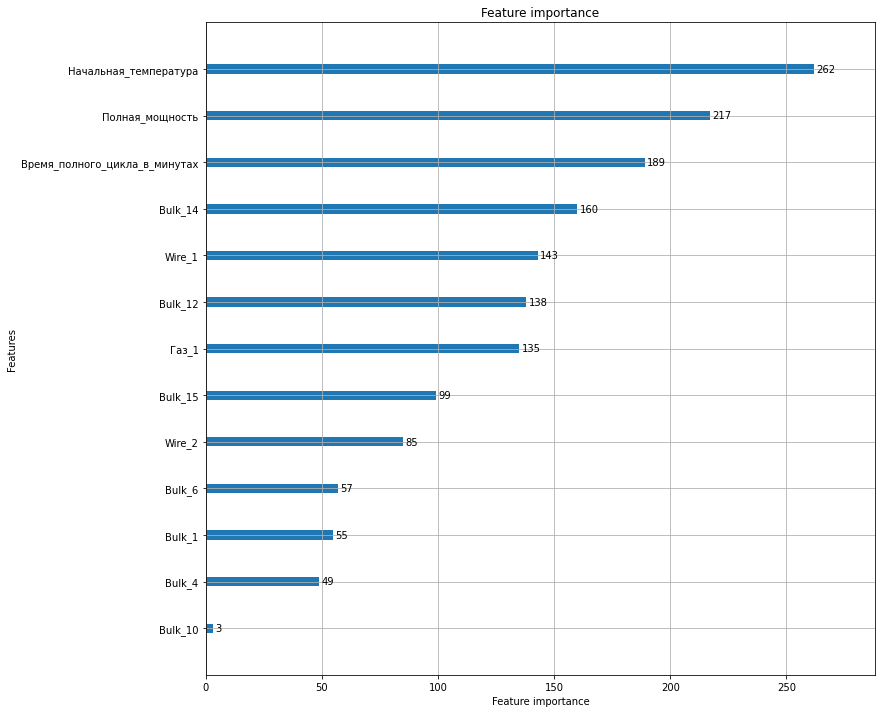

In [48]:
lgb.plot_importance(best_model, importance_type='split', figsize=(12, 12))
plt.show()

Данный график отображает важность признаков, построенный на основе количества разбиений данных по каждому признаку. Как мы видим, в топ-3 по важности входит начальная температура, наш искусственный признак - время полного цикла в минутах, а так же полная мощность нагрева дугой. 

По добавкам наибольшее влияние оказывает Bulk 14, Bulk 12 и Wire 1.

Теперь построим график важности через библиотеку SHAP.

In [49]:
explainer = shap.TreeExplainer(best_model) 

In [50]:
shap_values = explainer.shap_values(X_test)

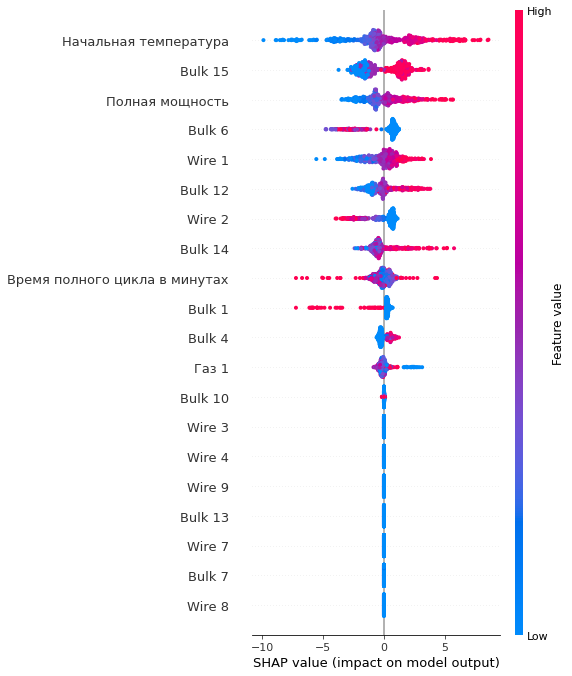

In [51]:
shap.summary_plot(shap_values, X_test) 

Из графика видно следующее:
1. Чем **меньше начальная температура**, тем **меньше будет предсказанная конечная температура** и наоборот, чем **выше начальная температура** - тем **выше конечная**. В этом плане все логично.
2. Чем **больше объем добавленной добавки Bulk 15, Bulk 12, Wire 1, Bulk 14**, тем **больше** предсказанная **конечная температура** и наоборот, чем **меньше** добавляли этой добавки(или вообще не добавляли), тем **ниже конечная температура**.
3. Чем **больше объем добавленной добавки Bulk 6, Bulk 1, Wire 2**, тем **ниже предсказанная конечная температура** и наоборот, чем **меньше** добавляли этой добавки, тем **выше конечная температура**.
4. Достаточно очевидно, что чем **выше полная мощность нагрева**, тем **выше** будет **конечная температура** и наоборот.
5. Со временем полного цикла в минутах все неоднозначно, скорее всего это связано с тем, что один состав при долгом нагреве может остаться "сравнительно" холодным, а другой состав нагреется больше, поэтому тут явно нельзя сказать, что при долгом нагреве должна быть более высокая температура, график говорит нам обратное.

## Итоговый вывод

В ходе работы над проектом мы прошли через следующие этапы:

**1. Загрузка данных**

Загрузка данных прошла корректно, все таблицы были корректны считаны.

**2. Исследовательский анализ и предобработка данных**

Первичный анализ показал нам, что в столбце с добавками, как порошковыми, так и проволочными, было много пропусков. С одной стороны это логично, ведь какие-то добавки в стали распространены, а какие-то добавляются редко. С другой стороны большое количество пропусков может запутать модель, поэтому при обучении было необходимо удалить пару столбцов. 

Также мы избавились от очевидных выбросов, по типу отрицательной мощности электрода и температуры менее 1500 градусов. На этом же этапе мы проверили корректность времени замеров с временем нагрева и подачей материалов, чтобы все соответствовало логике процесса. И также мы выделили только первую и последнюю температуру каждого цикла, поскольку промежуточные температуры являются утечкой информации при моделировании. Соответственно те ковши, у которых был только один цикл замера температуры, мы убрали, поскольку на их основе невозможно моделирование.

**3. Объединение данных и исследовательский анализ объединённого датафрейма**

Мы объединили все таблицы с корректными ключами(кроме времени) и получили итоговый датафрейм. Провели исследовательский анализ и добавили искусственный признак - время полного нагрева в минутах. Это немного помогло получить заданную метрику.

**4. Подготовка данных и обучение моделей**

Мы подготовили данные для обучения моделей, всего мы взяли для обучения три модели - DecisionTreeRegressor, KNeighborsRegressor и LGBMRegressor. Лучшей моделью оказалась LGBMRegressor(max_depth=3, min_child_samples=23, random_state=141024).

Метрика MAE лучшей модели на кросс-валидации: 6.82

MAE для LGBMRegressor на тесте: 6.7<6.8

**Общий вывод и рекомендации заказчику**

Наша модель ошибается в среднем по модулю на ..., что удовлетворяет запросу заказчика в 6.8. 

В ходе анализа важности признаков можно сказать следующее:

1. Добавление материалов под номерами Bulk 15, Bulk 12, Wire 1, Bulk 14 увеличивали температуру сплава, поэтому если цель повысить температуру при неизменных других параметрах, то стоит обратить внимание на эти добавки.
2. Добавление материалов под номерами Bulk 6, Bulk 1, Wire 2 наоборот понижало температуру сплава. Если цель в этом, то стоит обратить внимание на эти добавки.
3. Очевидно, что чем выше полная мощность нагрева, тем выше будет конечная температура и наоборот
4. Время нагрева неоднозначно влияет на предсказание модели, поскольку даже с физико-химической точки зрения больше будет влиять состав сплава, нежели время его нагрева. То есть условно берем сплав X с одним составом, сплав Y с другим (состав в данном случае имеет под собой смысл внесенных добавок), то за время n с одинаковой подаваемой мощностью оба сплава нагреются по-разному в силу разных добавок и как итог разной удельной теплоемкости сплавов.